In [176]:
import numpy as np
import pandas as pd 
import matplotlib as mpl
import matplotlib.pyplot as plt


from adv_finance import bars

In [177]:
%load_ext autoreload 
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
plt.style.use('seaborn-talk')
plt.style.use('bmh')
pd.set_option('display.max_rows', 100)


## Load Tick Data 

In [187]:
# * A122630 KODEX 레버리지(ISIN: KR7122630007)
# * A252670 KODEX 200선물인버스2X(ISIN: KR7252670005)
# * A233740 KODEX 코스닥150레버리지(ISIN: KR7233740000)
# * A251340 KODEX 코스닥150선물인버스(ISIN: KR7251340006)
# * A005930 삼성전자(ISIN:KR7005930003)

TRADE_A233740 = pd.read_parquet('/nfs/data/interim/TRADE_A233740.parq').set_index('TIME')
df = TRADE_A233740

In [194]:
dv_bars = bars.dollar_bars(df, 'DV', 1_000_000_000)
df = dv_bars

100%|██████████| 11946001/11946001 [00:05<00:00, 2342712.62it/s]


In [195]:
%%time
tidx = bars.get_imbalance(df.PRICE.values) * df.DV.iloc[1:]

wndo = tidx.shape[0] // 1000
wndo = 100
print(f"window size: {wndo:,.2f}")

E_bs = tidx.ewm(wndo).mean().abs()
E_T = pd.Series(range(tidx.shape[0]), index=tidx.index).ewm(wndo).mean()

df0 = (pd.DataFrame()
       .assign(E_T=E_T)
       .assign(E_bs=E_bs)
       .assign(absMul=lambda df: df.E_T * np.abs(df.E_bs))
       .assign(absTheta=tidx.cumsum().abs())       
      )

window size: 100.00
CPU times: user 273 ms, sys: 32 ms, total: 305 ms
Wall time: 303 ms


In [196]:
%%time
imb_bars0 = bars.agg_imb_bars(df0[100:])


CPU times: user 1.71 s, sys: 92.2 ms, total: 1.8 s
Wall time: 1.79 s


In [197]:
test_imb_bars0 = (pd.DataFrame(imb_bars0, columns=['start', 'stop', 'Ts'])
                 .drop_duplicates()
)

In [198]:
dv_imb_bars = df.PRICE.loc[test_imb_bars0.stop].drop_duplicates()
df_imb_bars = df.loc[dv_imb_bars.index]

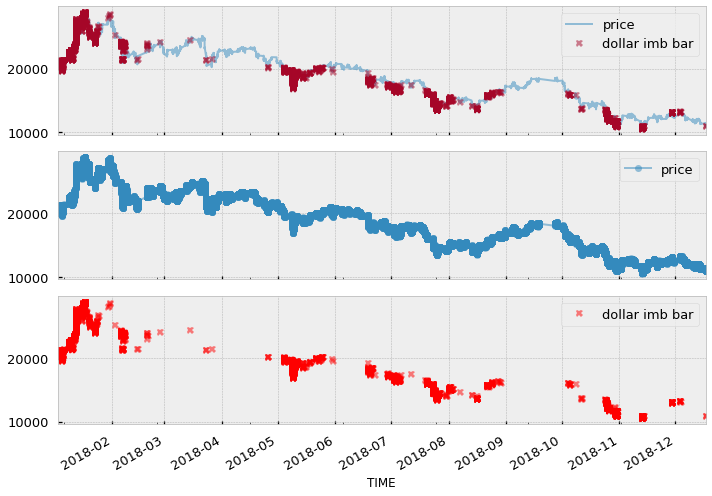

In [199]:
xDate = '2018'
xdf, xtdf = bars.select_sample_data(df, df_imb_bars, 'PRICE', xDate)
bars.plot_sample_data(xdf, xtdf, 'dollar imb bar', alpha=0.5, markersize=7)   


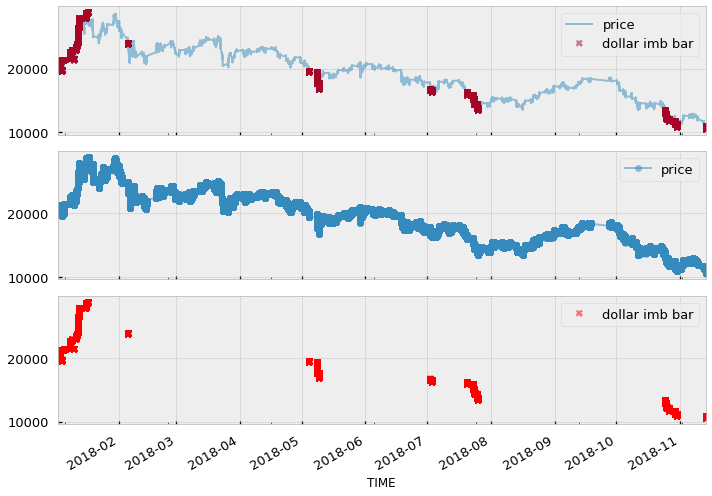

In [193]:
# 전체 틱 데이터로 TIB를 그릴 경우
xDate = '2018'
xdf, xtdf = bars.select_sample_data(df, df_imb_bars, 'PRICE', xDate)
bars.plot_sample_data(xdf, xtdf, 'dollar imb bar', alpha=0.5, markersize=7)   


# APPENDIX